In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import torch
import matplotlib.pyplot as plt
from estimators.data import TraversabilityDataset, get_transform
from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.utils import get_learner
from utilities.postprocessing.utils import KrockPatchExtractStrategy
from utilities.patches import *
from interpretability import *
from jupyterthemes import jtplot
from estimators.utils import load_model_from_name
import matplotlib
jtplot.reset()

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [3]:
plt.style.use(['science', 'ieee'])
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
# %matplotlib notebook
# matplotlib.rcParams['figure.figsize'] = (7,5)


In [4]:
model_name = 'microresnet#4-gate=3x3-n=1-se=True'
model_dir = '/media/francesco/Carino/vaevictis/data/microresnet#4-gate=3x3-n=1-se=True--0.001-0.66-1557073626.4222503'
BASE_DIR = '/media/francesco/saetta/krock-dataset/test/'
TEST_META = BASE_DIR + '/bags/meta.csv'
HM_DIR = '/media/francesco/saetta/krock-dataset/test/csvs_patches'
PATCHES_DIR = '/media/francesco/saetta/krock-dataset/test/patches/0.66/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
module = load_model_from_name(model_dir + '/roc_auc.pth', model_name )
module = module.eval()

In [5]:
ds = TraversabilityDataset.from_root(HM_DIR, patches_dir = PATCHES_DIR, time_window = 50*2, patch_size=0.66, tr=0.2, transform=get_transform(debug=False))
learner, _ = get_learner(model_name, model_dir, [], dataset=ds)
explain = ExplainModel.from_leaner(learner, ds)

/home/francesco/Documents/Master-Thesis/core/interpretability/__init__.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, ds.df])


27279


In [9]:
explain.by_looking_at().tell(ClassificationAnswer.from_explain).plot_confusion_matrix()
explanations = explain.by_looking_at([
                                      Shuffle(FalsePositive()),
                                      Shuffle(FalseNegative()),
                                      Shuffle(Worst()),
                                      Shuffle(Best()),
                                     ], how_many=5)

In [10]:
# explain.by_looking_at().tell(ClassificationAnswer.from_explain).plot_confusion_matrix()

In [11]:
import os
plt.style.use(['science', 'ieee'])

class MyExplanationsSaver():
    def __init__(self, base_dir):
        self.base_dir = base_dir
            
    def __call__(self, explanations):
        for name, explanation in explanations.items():
            answers = explanation.tell(PatchAnswer.from_explain)
#             print(name, answers)
            save_dir = '{}/{}'.format(self.base_dir, name)
            os.makedirs(save_dir, exist_ok=True)
            for i, answer in enumerate(answers):
                answer.plot2d().savefig('{}/patch-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.grad_cam(module, device).plot2d().savefig('{}/grad-cam-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.heatmap((8,8)).plot2d().savefig('{}/heatmap-2d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                answer.plot3d(title='', rstride=1, cstride=1,)[0].savefig('{}/patch-3d-{}'.format(save_dir,i), bbox_inches='tight', transparent=True)
                plt.close("all")
MyExplanationsSaver('/home/francesco/Documents/Master-Thesis/papers/Thesis/img/5/quarry/')(explanations)

# Analize Quarry Test Set
We are going to use the test set created from simulations run on the Quarry map to understand the model behaviour. We will try to answer different questions, such as "Which are the easiest traversable patches?" or "Are they any ground feature that can misslead the model?".

## Most traversable patches
We expect the esiest traversable patches to be mostly flat. The following figure shows five patches sorted by the *traversable* class probability from the test set.

In [13]:
%matplotlib notebook
plt.style.use(['science'])
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
matplotlib.rcParams['figure.figsize'] = (7,5)

In [14]:
_ = module.eval()

In [15]:
def plot_answer(answer):
    answer.plot2d()
    answer.grad_cam(module, device).plot2d()
    answer.heatmap((8,8)).plot2d()
    _ = answer.plot3d()[0]

Clearly, most of the patches are flat. The first patch is entirery flat, looking at the heights we can see that every value is zero. Interesting, the grad cam thinks highlights the middle of the patch. Grad cam creates a circle in the middle where the maximum activation point is exactly at the Krock's head position, 36 pixels from the left. Interesting, the highligthed region corespond to the Krock position while walking in flat ground. Correctly the full Krock footprint is highligthed while the corners are not taken into account since the robot won't ever reach them. So, our model is looking at the head position, at the robot footprint and at the future possible reachable region.

<IPython.core.display.Javascript object>


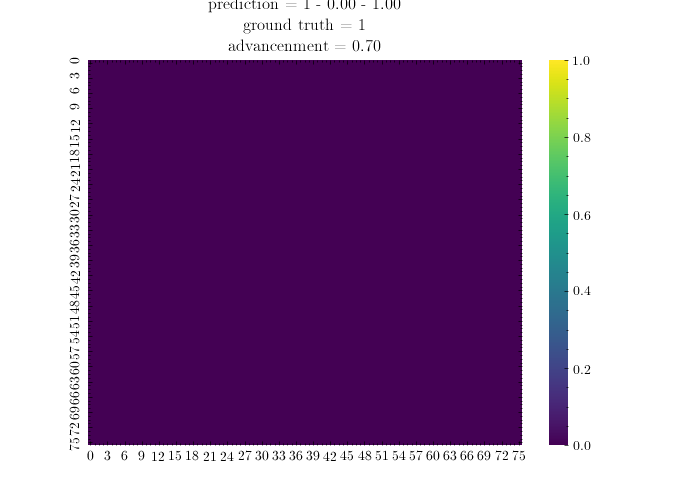

/home/francesco/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


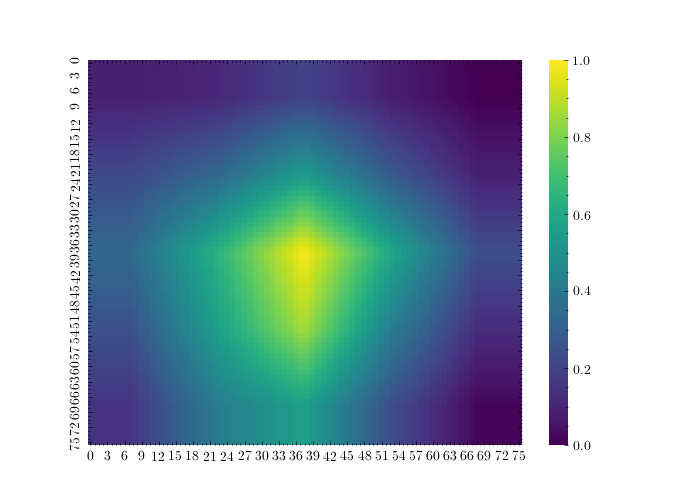

<IPython.core.display.Javascript object>


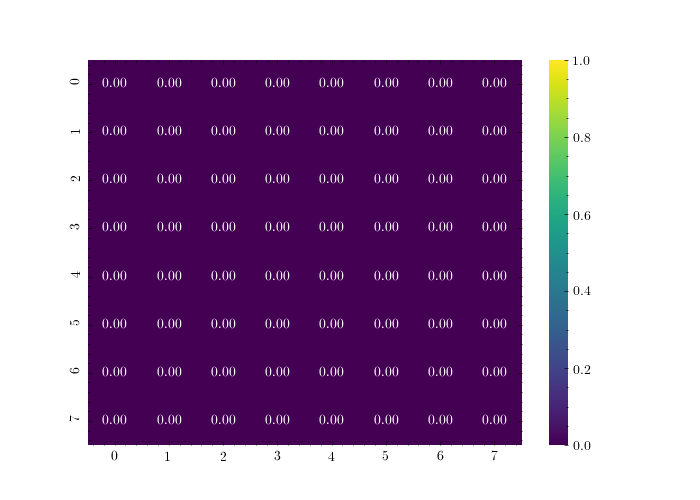

<IPython.core.display.Javascript object>


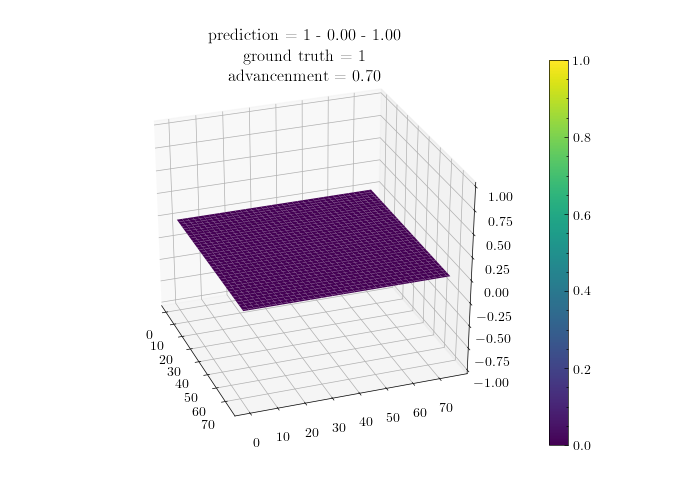

In [16]:
answers = explanations['best'].tell(PatchAnswer.from_explain)

plot_answer(answers[0])

In [ ]:
for answers in explanations.values():
    for answer in answers:
        answers[idx].plot2d()
        answers[idx].grad_cam(module, device).plot2d()
        answers[idx].heatmap((8,8)).plot2d()
        _ = answers[idx].plot3d()[0]
# answers[idx].add_advancement_using_simulator(3, 100).plot2d()

In [ ]:
??ax.view_init

In [ ]:
Patch.plot_all_2d(answers)

In [12]:
import gc

gc.collect()

99796